Возможные способы считывать аудио-файлы с помощью питона:

https://stackoverflow.com/questions/2060628/reading-wav-files-in-python

Stereo to Mono:

https://stackoverflow.com/questions/43056088/stereo-to-mono-wave-interpolation-in-python
https://stackoverflow.com/questions/30401042/stereo-to-mono-wav-in-python

Про считывание и записывание wave-файлов:

http://www.labbookpages.co.uk/audio/wavFiles.html

https://github.com/mbereket/music-transcription


Why is Fourier Transform so important?

https://dsp.stackexchange.com/questions/69/why-is-the-fourier-transform-so-important

Полезная презентация:

http://www.machinelearning.ru/wiki/images/c/cf/NizhibitskyMusicSlides.pdf


https://ru.wikipedia.org/wiki/Импульсно-кодовая_модуляция

## Data preparing 
### specifically for MAPS dataset

In [1]:
import soundfile as sf
import numpy as np
import os
import pandas as pd
from tqdm import tqdm
from IPython.display import clear_output
from tempfile import TemporaryFile
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab


# pd.set_option('display.max_rows', 20)

In [2]:
example_wav_path = 'MAPS/AkPnStgb/MUS/MAPS_MUS-alb_esp2_AkPnStgb.wav'
example_txt_path = 'MAPS/AkPnStgb/MUS/MAPS_MUS-alb_esp2_AkPnStgb.txt'
REL_PATH = 'MAPS/'
files = []

In [3]:
# checks if the files in the given triplet exists at all
def check_file_triplet_valid(triplet):
    for filename in triplet:
        if os.path.isfile(filename):
            continue
        else:
            raise Exception("The given file doesn't exist")
    return True

In [4]:

for f in os.scandir(REL_PATH):
    if f.is_dir():
        for (dirpath, dirnames, filenames) in os.walk(f.path):
            for file in filenames:
                if file.endswith(".wav"):
                    fullpath = dirpath + '/' + file # forms the path to the file
                    base = os.path.splitext(fullpath)[0] # gets the path to the file without its extention
                    triplet = [base + '.wav', base + '.mid', base + '.txt'] # forms the triplet of files: .wav, .mid, .txt
                    if check_file_triplet_valid(triplet):
                        files.append(triplet)


In [5]:
len(files)

29880

In [6]:
# transforms only 2-channel audiofile, others leaves untouched
def make_mono_audiofile(data):
    if data.shape[1] == 2:
        data = (data[:, 0] + data[:,1]) / 2
    return data
        
# переводит в данном датафрейме в полях "OnsetTime" и "OffsetTIme" время в секундах в номер фрейма
def translate_time_to_sample_number(data):
    data["OnsetTime"] = np.round(data.values[:, 0] * SAMPLERATE).astype(int)
    data["OffsetTime"] = np.round(data.values[:, 1] * SAMPLERATE).astype(int)
    return data

#### A sample is the smallest usable quantum of digital audio. The term frame isn't formally defined in pure audio terms, but is often used in relation to video that may accompany an audio track. In that context a frame is the quantity of audio samples taken during a video frame interval.

According to my copy of the absolutely essential (!) Master Handbook of Acoustics, to hear shorter tones, that is sounds with a short impulse, they need to be louder:

A 1,000-Hz tone sounds like 1,000 Hz in a 1-second tone burst, but an extremely short burst sounds like a click. The duration of such a burst also influences the perceived loudness. Short bursts do not sound as loud as longer ones... A pulse 3 milliseconds long must have a level about 15dB higher to sound as loud as a 0.5-second (500 millisecond) pulse. Tones and random noise follow roughly the same relationship in loudness vs. pulse length.

The 100-msec region is significant... Only when the tones or noise bursts are shorter than this amount must the sound-pressure level be increased to produce a loudness equal to that of long pulses or steady tones or noise. This 100 msec appears to be the integrating time or the time constant of the human ear. (Everest 2001, 60-61)

In [4]:
WINDOW_SIZE = 16384 # samples per frame
SAMPLERATE = 44100 # samples per sec
MIDI_PITCH_AMOUNT = 128
DEBUG_MODE = True
SAVE_DATA_TO_FILE_PERIOD = 50

# считаем, что нота прозвучала во время фрейма, только если количество 
# семплов проигрывающих данную ноту в этой фрейме превышает MIN_SAMPLES_PRESENT
MIN_SAMPLES_PRESENT = 0.1 * SAMPLERATE / 2

midi_statistics = np.zeros(MIDI_PITCH_AMOUNT)

In [8]:
# returns frames (numpy.ndarray of the shape (None, WINDOW_SIZE))
# and labels (numpy.ndarray of the shape (None, MIDI_PITCH_NUM))) for an audiofile
def preprocess_audiofile(path_wav, path_txt):
    
    # data (numpy.ndarray) – a two-dimensional NumPy array is returned,
    # where the channels are stored along the first dimension, i.e. as columns. 
    data_wav, samplerate = sf.read(path_wav)
    data_txt = pd.read_csv(path_txt, sep="\t", header=0)

    assert(samplerate==SAMPLERATE)
    
    data_wav = make_mono_audiofile(data_wav)
    data_txt = translate_time_to_sample_number(data_txt)
    chunks_amount = len(data_wav) // WINDOW_SIZE
    samples_amount = WINDOW_SIZE * chunks_amount
    # отбрасываем конец аудиофайла, если количество
    # сэмплов в нем НЕ делится ровно на WINDOW_SIZE
    data_wav = data_wav[:samples_amount] 
    
    # делим data_wav на одинаковые chunks_amount, если длина data_wav
    # НЕ делится ровно на chunks_amount, то np.split должен будет выбросить exception
    frames = np.array(np.split(data_wav, chunks_amount))
    labels = np.array(get_labels_for_audiofile(data_txt, frames))
    
    if DEBUG_MODE:
        print("==== preprocessing file: {} ====".format(path_wav))
        print("frames shape: {}".format(frames.shape))
        print("labels shape: {}".format(labels.shape))
        assert frames.shape[0] == labels.shape[0], "frames.shape[0] should be equal to labels.shape[0]"
    return frames, labels
    

In [9]:
def get_labels_for_audiofile(data_txt, frames):
    
    # Для каждого frame'a заданного размера WINDOW_SIZE хотим создать label,
    # который представляет из себя вектор из 0 и 1 размера MIDI_PITCH_AMOUNT,
    # обозначающий, звучала ли соответствующая нота во время этого frame'a или нет
    # инициализируем все нулями
    labels = np.zeros((len(frames), MIDI_PITCH_AMOUNT), dtype=int)
    
    for i in np.arange(data_txt.shape[0]):

        onset_time = data_txt.values[i][0]
        offset_time = data_txt.values[i][1]
        midi_pitch = data_txt.values[i][2]
        midi_statistics[midi_pitch] += 1
        
        begin_frame = onset_time // WINDOW_SIZE
        end_frame = offset_time // WINDOW_SIZE
        
        
        for frame_num in np.arange(begin_frame, end_frame + 1):
            
            if frame_num == begin_frame:
                if (((begin_frame + 1) * WINDOW_SIZE - 1) - onset_time) > MIN_SAMPLES_PRESENT:
                    # помечаем, что данный midi_pitch звучал в рассматриваемом frame'e
                    labels[begin_frame][midi_pitch] = 1
                    continue
            if frame_num == end_frame:
                if (offset_time - (end_frame * WINDOW_SIZE)) > MIN_SAMPLES_PRESENT:
                    labels[end_frame][midi_pitch] = 1
                    continue
                    
            # если между begin_frame и end_frame есть хотя бы один frame, то очевидно,
            # что данный midi_pitch звучал на протяжении всего frame'a
            labels[frame_num][midi_pitch] = 1

    return labels
    

### Теперь мы готовы обработать все имеющиеся аудиофайлы, и подготовить data (X) и labels (y) для будущей нейронной сети

In [10]:
def preprocess_all_audiofiles(files):
    
    X = np.array([])
    y = np.array([])
    num_files = len(files)
    
    for i in np.arange(len(files)):
        
        print("! {}/{}".format(i, num_files))
        
        file_triplet = files[i]
        file_data, file_labels = preprocess_audiofile(file_triplet[0], file_triplet[2])
        if len(X) == 0 and len(y) == 0: # инициализация
            X = file_data
            y = file_labels
        else:
            X = np.concatenate((X, file_data), axis=0)
            y = np.concatenate((y, file_labels), axis=0)
            
        if DEBUG_MODE:
            print("---- current X shape: {}".format(X.shape))
            print("---- current y shape: {}".format(y.shape))
            
        # сохраняем обработанные данный на диск, на всякий случай
        if i % SAVE_DATA_TO_FILE_PERIOD == 0:
            np.save("X_data.npy", X)
            np.save("y_data.npy", y)
            np.save("midi_statistics.npy", midi_statistics)
            # np.load("outfile.npy")
        
        clear_output()
        
    print("============ OVERALL X shape: {} ============".format(X.shape))
    print("============ OVERALL y shape: {} ============".format(y.shape))

    return X, y

In [11]:
X, y = preprocess_all_audiofiles(files)

! 1027/29880
==== preprocessing file: MAPS/SptkBGAm/UCHO/I32-96/C0-4-7-10-13/MAPS_UCHO_C0-4-7-10-13_I32-96_S0_n2_SptkBGAm.wav ====
frames shape: (9, 16384)
labels shape: (9, 128)


KeyboardInterrupt: 

В этот момент было решено, что заранее обрабатывать все файлы каждый раз -- мучительно долго. Можно было бы обработать все один раз и записать все на диск. Но по предварительный подсчетам данных получилось бы слишком много, поэтому самым разумным решением было бы обрабатывать файлы и создавать батчи прямо во время обучения.

In [5]:
X = np.load("X_data.npy")
y = np.load("y_data.npy")

In [6]:
X.shape
y.shape

(24355, 128)

In [6]:
midi_statistics = np.load("midi_statistics.npy")

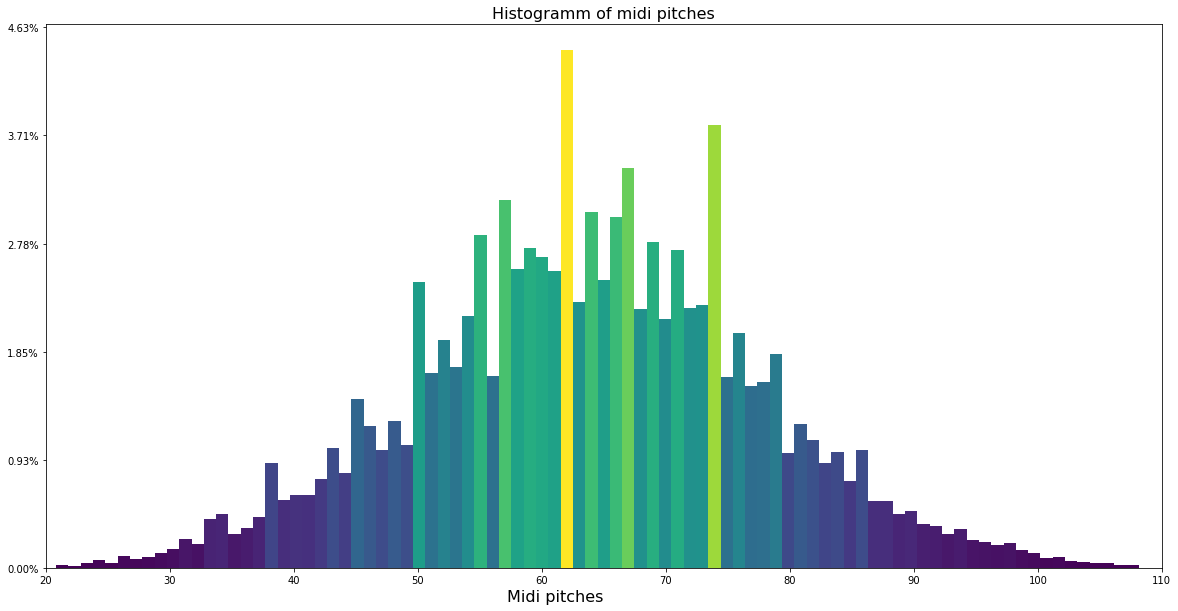

In [7]:
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
plt.figure(figsize=(20,10))
axes = plt.gca()
axes.set_xlim([20,110])
# axes.set_ylim([ymin,ymax])
# N is the count in each bin, bins is the lower-limit of the bin
N, bins, patches = plt.hist(np.arange(128), bins=128, weights=midi_statistics)
# We'll color code by height, but you could use any scalar
fracs = N / N.max()
# we need to normalize the data to 0..1 for the full range of the colormap
norm = colors.Normalize(fracs.min(), fracs.max())
# plt.grid(True)
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

axes.set_title('Histogramm of midi pitches', fontdict = {'fontsize': 16})
axes.set_xlabel('Midi pitches', fontdict = {'fontsize': 16, 'horizontalalignment': 'right'})
# Now we format the y-axis to display percentage
axes.yaxis.set_major_formatter(PercentFormatter(xmax=np.sum(midi_statistics)))
plt.show()

## ITS TENSORFLOW TIME BABY

### Прямое дискретное преобразование Фурье
$ X_k = \sum\limits_{n=0}^{N-1} x_n e^{-\frac{2 \pi i}{N} k n} = \sum\limits_{n=0}^{N-1} x_n\cdot [\cos(2 \pi k n / N) - i\cdot \sin(2 \pi k n / N)], \qquad (k = 0, \dots, N-1). $

Given an input tensor of shape [batch, in_height, in_width, in_channels] and a filter / kernel tensor of shape [filter_height, filter_width, in_channels, out_channels], this op performs the following:

In [7]:
# Эта модель использует при свертке short-time Fourier transform,
# оттого так и называется
class STFT():
    def __init__(self):
        self.learning_rate = tf.placeholder(tf.float32, shape=None, name='learning_rate')
        self.stride = 512
        self.receptive_field = 4096
        self.start_freq = 50
        self.end_freq = 6000
        self.filters_amount= 512
        self.batch_size = 64
        
        self.frequencies = np.logspace(np.log(self.start_freq),
                                       np.log(self.end_freq),
                                       self.filters_amount,
                                       base=np.e,
                                       endpoint=True)
        
        self.discrete_time = np.arange(self.receptive_field)
        
        # number of lvl1 features
        self.regions = (WINDOW_SIZE - self.receptive_field)/self.stride + 1
        
        # the shape of wsin and wcos is (1, 4096, 1, 512) for now
        self.wsin = np.empty((1, self.receptive_field, 1, self.filters_amount), dtype=np.float32)
        self.wcos = np.empty((1, self.receptive_field, 1, self.filters_amount), dtype=np.float32)
        self.create_filters()
        
        # 'ph' stands for 'placeholder'
        self.input_X_ph = tf.placeholder('float32', [None, 1, WINDOW_SIZE, 1], name="input_X")
        self.input_y_ph = tf.placeholder('float32', [None, MIDI_PITCH_AMOUNT], name="input_y")
        self.pred_y_ph = tf.placeholder('float32', [None, MIDI_PITCH_AMOUNT], name="pred_y")

        self.wsin_var = tf.constant(value=self.wsin, dtype='float32', name="wsin")
        self.wcos_var = tf.constant(value=self.wcos, dtype='float32', name="wcos")

        self.loss = None
        self.optimizer_step = None
                
            
    def create_filters(self):
        for i in np.arange(self.filters_amount):
            current_freq = self.frequencies[i]
            args = 2 * np.pi * current_freq * self.discrete_time / self.receptive_field
            self.wsin[0, :, 0, i] = np.sin(args)
            self.wcos[0, :, 0, i] = np.cos(args)      
        
        
    def define_graph(self):
        
        conv_sin = tf.nn.conv2d(input=self.input_X_ph,
                                filter=self.wsin_var,
                                strides=[1, 1, self.stride, 1],
                                padding="VALID")
        conv_cos = tf.nn.conv2d(input=self.input_X_ph,
                                filter=self.wcos_var,
                                strides=[1, 1, self.stride, 1],
                                padding="VALID")
        
        fourier_values_module_square = tf.square(conv_sin) + tf.square(conv_cos)
        
        # Output tensor the same shape as inputs except the last dimension is of size units.
        dense_layer = tf.layers.Dense(units=MIDI_PITCH_AMOUNT)
        
        
        
        self.pred_y_ph = dense_layer(tf.reshape(tf.log(fourier_values_module_square + 10e-12),
                                                shape=[self.batch_size, tf.to_int32(self.regions * self.filters_amount)]))
        
        self.loss = tf.reduce_mean(tf.nn.l2_loss(self.input_y_ph - tf.reshape(self.pred_y_ph, [self.batch_size, MIDI_PITCH_AMOUNT])) / MIDI_PITCH_AMOUNT)
        self.optimizer_step = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.loss)
        
        
        
    def train(self, X, y, sess, lr):
        
        loss, _ = sess.run([self.loss, self.optimizer_step], feed_dict={self.input_X_ph: X,
                                                 self.input_y_ph: y,
                                                 self.learning_rate: lr})
        return loss


### Train

In [15]:
stft = STFT()
stft.define_graph()
tf.trainable_variables()


[<tf.Variable 'dense/kernel:0' shape=(12800, 128) dtype=float32_ref>,
 <tf.Variable 'dense/bias:0' shape=(128,) dtype=float32_ref>]

In [17]:
sess = tf.InteractiveSession()

# присвоить всем переменным их initial_value
sess.run(tf.global_variables_initializer())

In [18]:
def get_batches(X, y, batch_size):
    n_samples = X.shape[0]
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        
        end = min(start + batch_size, n_samples)
        if end == n_samples:
            break
        batch_idx = indices[start:end]
    
        yield X[batch_idx], y[batch_idx]

In [21]:
loss_history = []

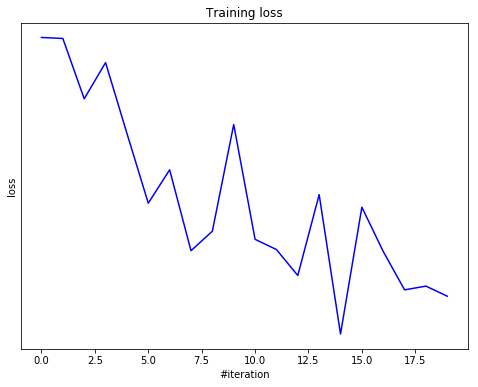

Current loss: 34.213142


In [23]:

n_epoch = 10
lr = 0.000000001
for i in range(n_epoch):
    epoch_loss = []
    for x_batch, y_batch in get_batches(X, y, stft.batch_size):
        x_batch = np.reshape(x_batch, (stft.batch_size, 1, WINDOW_SIZE, 1))
        loss = stft.train(x_batch, y_batch, sess, lr)
        epoch_loss.append(loss)
    
    loss = np.mean(epoch_loss)
    loss_history.append(loss)
    clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.yscale("log")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)

In [13]:
tf.reset_default_graph()

In [14]:
tf.trainable_variables()

[]

In [16]:
sess.close()